## Cеминар 1. Классификация текста

В этом семинаре мы будем работать с датасетом для классификации AG News. Он содержит более 100 тысяч текстов с 4-мя метками: World, Sports, Business, Sci/Tech. Соответственно, мы будем решать задачу классификации текста.

#### План

1. Обработка текста
1. TF-IDF
1. Обучение сверточных сетей на эмбедингах Word2Vec
    1. Простая CNN
    1. TextCNN
1. Дообучение эмбеддингов вместе с моделью

In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import wandb

wandb.login()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/dalabaya/anaconda3/envs/ml-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dalabayabilay (dalabayabilay-kazakh-british-technical-university). Use `wandb login --relogin` to force relogin


device(type='cuda')

Загрузим данные.

In [2]:
data_train = pd.read_csv('data/ag_news_train.csv', sep='\t')
data_test = pd.read_csv('data/ag_news_test.csv', sep='\t')

In [3]:
labels_train = data_train['label']
labels_test = data_test['label']

In [4]:
len(data_train), len(data_test)

(120000, 7600)

Проверим сбалансированность классов, чтобы понять, какую метрику использовать.

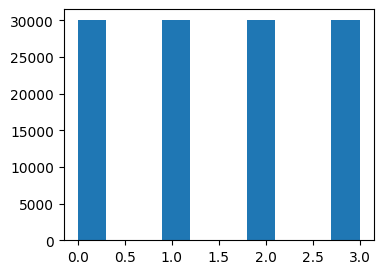

In [5]:
plt.figure(figsize=(4, 3))
plt.hist(labels_train);

Иногда для знакомства с датасетом бывает полезно взглянуть на облако слов.

In [7]:
from wordcloud import WordCloud

def create_cloud_graph(corpus):
    wordcloud = WordCloud(
        width=1600, height=800, max_words=200, background_color='white', collocations=False
    ).generate(' '.join(corpus))
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

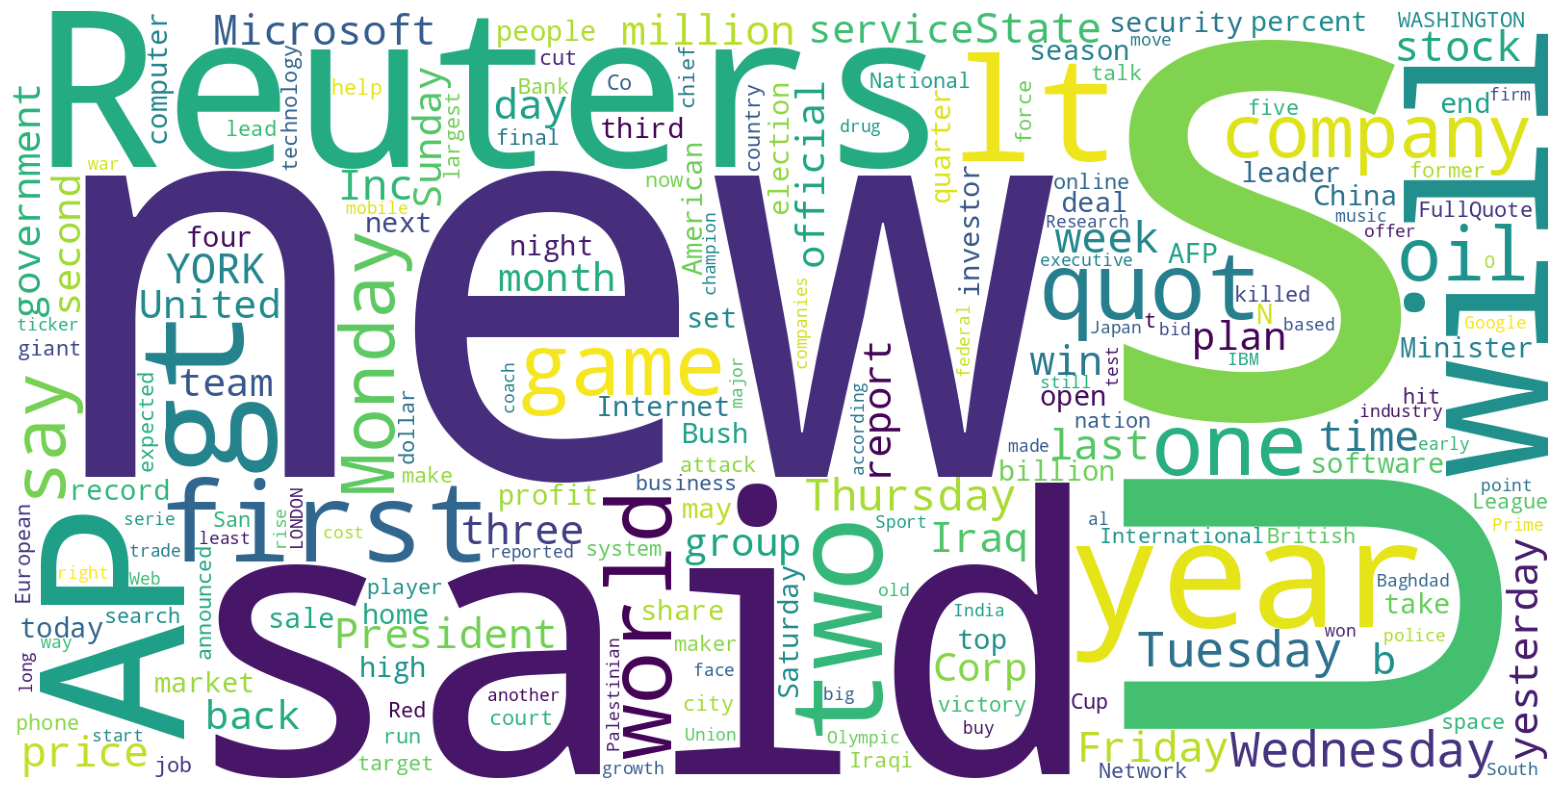

In [8]:
create_cloud_graph(data_train['text'])

### TF-IDF

В качестве бейзлайна обучим линейную регрессию поверх признаков tf-idf.

1. __Term frequency__:
$$\text{tf}(t, d) = \frac{N(t, d)}{\sum_{k \in V} N(k, d)},$$
где $N(t, d)$ — количество вхождений слова $t$ в текст $d$.
1. __Inverse Document Frequency__
$$\text{idf}(t, D) = \log \frac{|D|}{|\{d \in D | t \in d\}|},$$

где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.


$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


def train_eval_model(train_X, test_X, train_y, test_y):
    model = LogisticRegression(max_iter=500)
    model.fit(train_X, train_y)

    train_pred = model.predict(train_X)
    test_pred = model.predict(test_X)

    train_acc = accuracy_score(train_y, train_pred)
    test_acc = accuracy_score(test_y, test_pred)

    print('Train accuracy:', round(train_acc, 3))
    print('Test accuracy: ', round(test_acc, 3))

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
tfidf_vectorizer = TfidfVectorizer(min_df=4, max_df=0.95)
tfidf_vectorizer.fit(data_train['text']);

In [12]:
tfidf_train = tfidf_vectorizer.transform(data_train['text'])
tfidf_test = tfidf_vectorizer.transform(data_test['text'])

In [13]:
train_eval_model(tfidf_train, tfidf_test, labels_train, labels_test)

Train accuracy: 0.94
Test accuracy:  0.918


Проблема tf-idf в том, что он не учитывает комбинации слов. Для того, чтобы это исправить, можно брать n-граммы слов в качестве признаков. Попробуем взять n с 1 до 3. Ограничим еще размер словаря, чтобы признаков было не так много.

In [14]:
tfidf_vectorizer = TfidfVectorizer(min_df=10, max_df=0.95, ngram_range=(1, 3))
tfidf_vectorizer.fit(data_train['text']);

In [15]:
tfidf_train = tfidf_vectorizer.transform(data_train['text'])
tfidf_test = tfidf_vectorizer.transform(data_test['text'])

In [16]:
train_eval_model(tfidf_train, tfidf_test, labels_train, labels_test)

Train accuracy: 0.951
Test accuracy:  0.92


## Сверточные нейронные сети

Обучать нейронные сети не так просто, надо сначала предобработать датасет.

### Токенизация

Токенизация - это деление текста на токены (в простейшем случае отдельные слова).

Токенизацию проще всего реализовать с помощью [регулярных выражений](https://docs.python.org/3/library/re.html). Но можно и без них.

In [17]:
import re

def tokenize(text):
    reg = re.compile(r'\w+')
    return reg.findall(text)

In [18]:
data_tok_train = [tokenize(t.lower()) for t in data_train['text']]
data_tok_test = [tokenize(t.lower()) for t in data_test['text']]

In [19]:
print(data_tok_train[:2])

[['wall', 'st', 'bears', 'claw', 'back', 'into', 'the', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 's', 'dwindling', 'band', 'of', 'ultra', 'cynics', 'are', 'seeing', 'green', 'again'], ['carlyle', 'looks', 'toward', 'commercial', 'aerospace', 'reuters', 'reuters', 'private', 'investment', 'firm', 'carlyle', 'group', 'which', 'has', 'a', 'reputation', 'for', 'making', 'well', 'timed', 'and', 'occasionally', 'controversial', 'plays', 'in', 'the', 'defense', 'industry', 'has', 'quietly', 'placed', 'its', 'bets', 'on', 'another', 'part', 'of', 'the', 'market']]


### Удаление стоп-слов

__`nltk`__ - это огромная библиотека для работы с текстом (сравнимо с `numpy` для матриц). В ней реализованы методы для [токенизации](https://www.nltk.org/api/nltk.tokenize.html), [лемматизации](https://www.nltk.org/api/nltk.stem.wordnet.html), [стемминга](https://www.nltk.org/api/nltk.stem.html) и многого другого. 

In [22]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dalabaya/nltk_data...


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
def remove_stopwords(tokenized_texts):
    clear_texts = []
    for words in tokenized_texts:
        clear_texts.append([word for word in words if word not in stop_words])

    return clear_texts

In [24]:
data_tok_train = remove_stopwords(data_tok_train)
data_tok_test = remove_stopwords(data_tok_test)

In [25]:
print(data_train['text'][50])
print(data_tok_train[50])

Making Your Insurer Pay If Hurricane Charley blows your house down, how can you make your insurance company pay?
['making', 'insurer', 'pay', 'hurricane', 'charley', 'blows', 'house', 'make', 'insurance', 'company', 'pay']


### Лемматизация


__Лемматизация__ — процесс приведения слова к его нормальной форме (**лемме**):
- для существительных — именительный падеж, единственное число;
- для прилагательных — именительный падеж, единственное число, мужской род;
- для глаголов, причастий, деепричастий — глагол в инфинитиве.

Для английского языка – `nltk.stem.WordNetLemmatizer`.   
Для русского – `pymorphy2.MorphAnalyzer`.

Лемматизация – самый популярный способ уменьшения размера словаря.

In [28]:
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

def lemmatize_text(tokenized_texts):
    lemmatized_data = []
    lemmatizer = WordNetLemmatizer()
    for words in tqdm(tokenized_texts):
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        lemmatized_data.append(lemmatized_words)
    return lemmatized_data

[nltk_data] Downloading package wordnet to /home/dalabaya/nltk_data...


In [29]:
lemmatized_train = lemmatize_text(data_tok_train)
lemmatized_test = lemmatize_text(data_tok_test)

100%|██████████| 7600/7600 [00:00<00:00, 17876.98it/s]


## Эмбеддинги слов

Для получения эмбеддингов обучим [Word2Vec](https://ru.wikipedia.org/wiki/Word2vec).

In [31]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    lemmatized_train,
    vector_size=100,
    min_count=4,
    window=5
).wv

In [32]:
w2v_model.get_vector('word')

array([-3.8566065e-01, -4.5641172e-01,  7.8815073e-01, -8.1760967e-01,
        5.4485458e-01, -2.5039529e-02,  2.1732053e-01,  6.0327774e-01,
        8.4837002e-01,  2.0129755e-01, -1.0491552e+00,  1.2267311e-01,
        2.6046905e-01,  3.6436233e-01,  2.6962036e-01, -1.1200856e+00,
       -3.1908035e-01, -2.0429289e-01,  1.0432731e+00, -1.0668521e-01,
        1.7163301e-01,  4.8022133e-01,  5.4591596e-01,  9.3287343e-01,
       -4.7785670e-01,  1.6914428e+00,  1.4775184e-01, -1.5795657e-01,
        7.3963797e-01,  1.8535247e+00, -1.7804663e-03,  3.7529901e-01,
       -1.4405461e-01, -7.9389852e-01,  3.8938141e-01,  1.8506862e-01,
       -2.3131916e-01,  6.6218531e-01,  2.9362115e-01, -1.2841882e+00,
        1.2638527e-01,  8.3911079e-01, -5.3450596e-01, -1.2598894e+00,
        5.3063352e-02, -6.9019395e-01, -2.6395208e-01,  1.2893775e+00,
       -1.0424080e-01,  1.1705267e+00,  5.0080699e-01,  5.9739351e-01,
        9.1444963e-01,  2.9191276e-01, -6.4871538e-01,  5.5561042e-01,
      

Скорвертируем все тексты в датасете в наборы эмбеддингов слов.

In [33]:
def encode_dataset(dataset):
    encoded = []
    for words in dataset:
        vectors = [w2v_model.get_vector(word) for word in words if word in w2v_model]
        encoded.append(torch.from_numpy(np.array(vectors)))

    return encoded

In [34]:
train_embeddings = encode_dataset(lemmatized_train)
test_embeddings = encode_dataset(lemmatized_test)

Оценим длины текстов. Это нужно для того, чтобы понимать, какого размера выбирать модель. Сверточные нейронные сети лучше всего работают на коротких текстах (до 20 слов). В нашем случае тексты длиннее.

Вспомним, что с помощью TF-IDF мы получали точность __0.92__. Будем сравнивать нашу модель с этим значением.

Text(0, 0.5, 'Count')

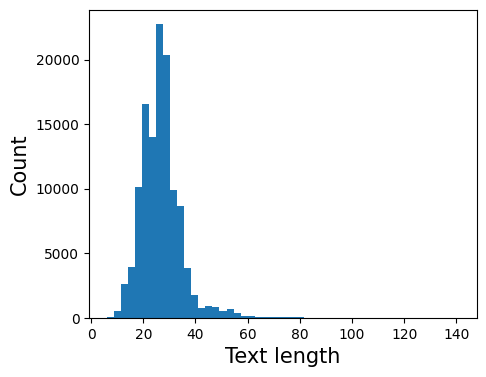

In [35]:
text_lens = [len(x) for x in train_embeddings]

plt.figure(figsize=(5, 4))
plt.hist(text_lens, bins=50);
plt.xlabel('Text length', size=15)
plt.ylabel('Count', size=15)

### Создание датасета из эмбеддингов

In [36]:
train_dataset = list(zip(train_embeddings, labels_train))
test_dataset = list(zip(test_embeddings, labels_test))

Функция `collate_fn` вызывается внутри `DataLoader` для батча данных. Используем ее для дополнения текстов паддингами.

In [37]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    x, labels = zip(*batch)
    return pad_sequence(x).permute(1, 0, 2), torch.tensor(labels)

In [38]:
from torch.utils.data import DataLoader

w2v_train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=True, batch_size=32)
w2v_test_loader = DataLoader(test_dataset, collate_fn=collate_fn, shuffle=False, batch_size=8)

Проверим, правильно ли выглядит батч данных. Видим, что короткие тексты заканчиваются векторами из 0 (паддингами).    
Второй элемент батча – тензор целевых переменных. Все так, как и должно быть!

In [39]:
batch = next(iter(w2v_test_loader))
batch

(tensor([[[-0.2384, -1.1063, -0.7232,  ..., -0.6864,  0.5168,  2.7849],
          [ 2.6680, -0.4203, -1.3965,  ...,  1.3288,  2.3679, -3.4257],
          [-1.7755,  0.7843, -1.3772,  ...,  0.5777,  1.4256, -1.3138],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-1.1195,  1.0697,  0.1888,  ..., -3.7530, -2.5822,  0.8690],
          [-1.6800,  1.7861, -1.7963,  ..., -3.2379, -0.3609, -1.9650],
          [-0.7545,  1.4292, -1.2944,  ...,  0.1076, -0.1980,  0.4154],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.1248,  0.2769,  0.1374,  ..., -0.4038,  0.0466, -0.1943],
          [ 1.5204,  1.8144,

## Сверточная нейронная сеть

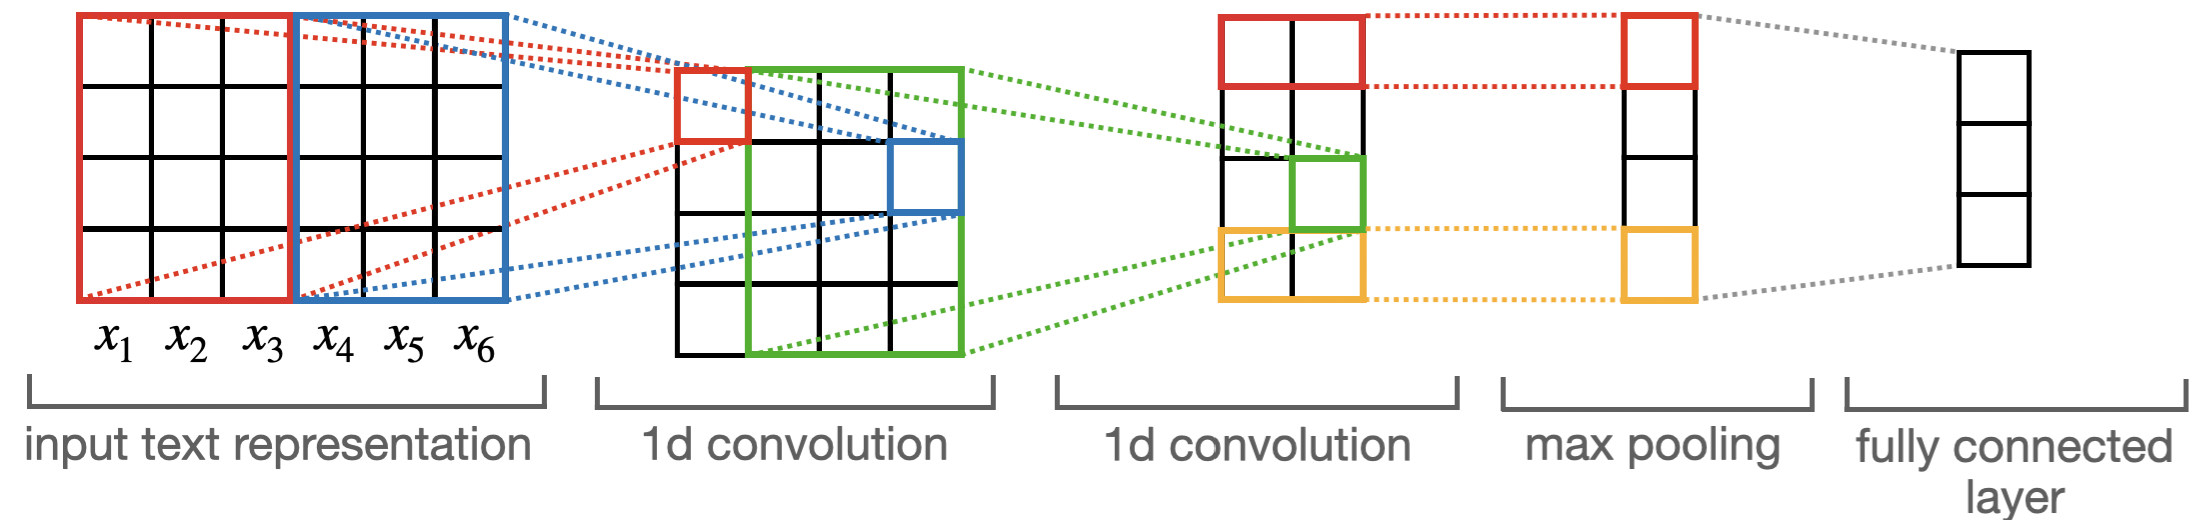

In [40]:
from torch import nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, hid_dim=100, n_classes=4):
        super().__init__()
        
        # не меняем число каналов
        self.conv1 = nn.Conv1d(hid_dim, hid_dim, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv1d(hid_dim, hid_dim, kernel_size=3, stride=1, padding=0)

        self.fc = nn.Linear(hid_dim, n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: [batch_size, seq_len, dim]
        # меняем местами размерности, так как число каналов (dim) должно стоять на втором месте
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        
        x = F.max_pool1d(x, x.size(-1)).squeeze(dim=-1)
        
        x = self.fc(x)
        return x

In [41]:
def train(model, dataloader, optimizer):
    """
    Обучает модель (model) на всем наборе данных (dataloader).
    """
    
    # не забываем переводить в train режим
    model.train()
    criterion = nn.CrossEntropyLoss()

    for i, (tokens, labels) in enumerate(dataloader):
        tokens = tokens.to(device)
        labels = labels.to(device)

        logits = model(tokens)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # логируем значения ошибки и точности
        wandb.log({
            "train_loss": loss.item(),
            "train_accuracy": (logits.argmax(-1) == labels).float().mean().item()
        })


@torch.inference_mode()
def evaluate(model, dataloader):
    """
    Тестирует модель (model) на всем наборе данных (dataloader).
    """
    
    # не забываем переводить в eval режим
    model.eval()
    criterion = nn.CrossEntropyLoss()

    correct = []
    losses = []
    for i, (tokens, labels) in enumerate(dataloader):
        tokens = tokens.to(device)
        labels = labels.to(device)

        logits = model(tokens)
        loss = criterion(logits, labels)

        correct.extend((logits.argmax(-1) == labels).float().cpu())
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    accuracy = np.mean(correct)
    
    # логируем тестовые значения ошибки и точности
    wandb.log({
        "test_loss": mean_loss,
        "test_accuracy": accuracy
    })

    return accuracy, mean_loss

In [42]:
# инициализируем модель и переводим на GPU, если есть
model = SimpleCNN().to(device)

# используем Adam для обучения
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [43]:
wandb.init(project="nlp_lesson2", name="simple_cnn")

In [44]:
# учим в течение 5 эпох
for epoch in range(5):
    train(model, w2v_train_loader, optimizer)
    test_accuracy, test_loss = evaluate(model, w2v_test_loader)

wandb.finish()

test_accuracy,▁▄▆▇█
test_loss,█▅▄▂▁
train_accuracy,▁▆▇▅▆▂▄▆▅▅▅▅▄▄▆█▇▅▄▅▅▄▅▅▅▅▅▂▆▇▃▇▇▅▄▅▅▇▅▇
train_loss,▅▃▇▄▅▅▄▅▄▃▇▆▅▅▅▅▇▃▃▃▆█▄▂▆▁▁▄▅▄▄▄▂▂▄▅▄▁▅▄
test_accuracy,0.89987
test_loss,0.29222
train_accuracy,0.875
train_loss,0.40699


In [62]:
print('SimpleCNN')
print('Test accuracy:', test_accuracy)
print('Test loss:', test_loss)

SimpleCNN
Test accuracy: 0.895
Test loss: 0.2985722840430313


## TextCNN

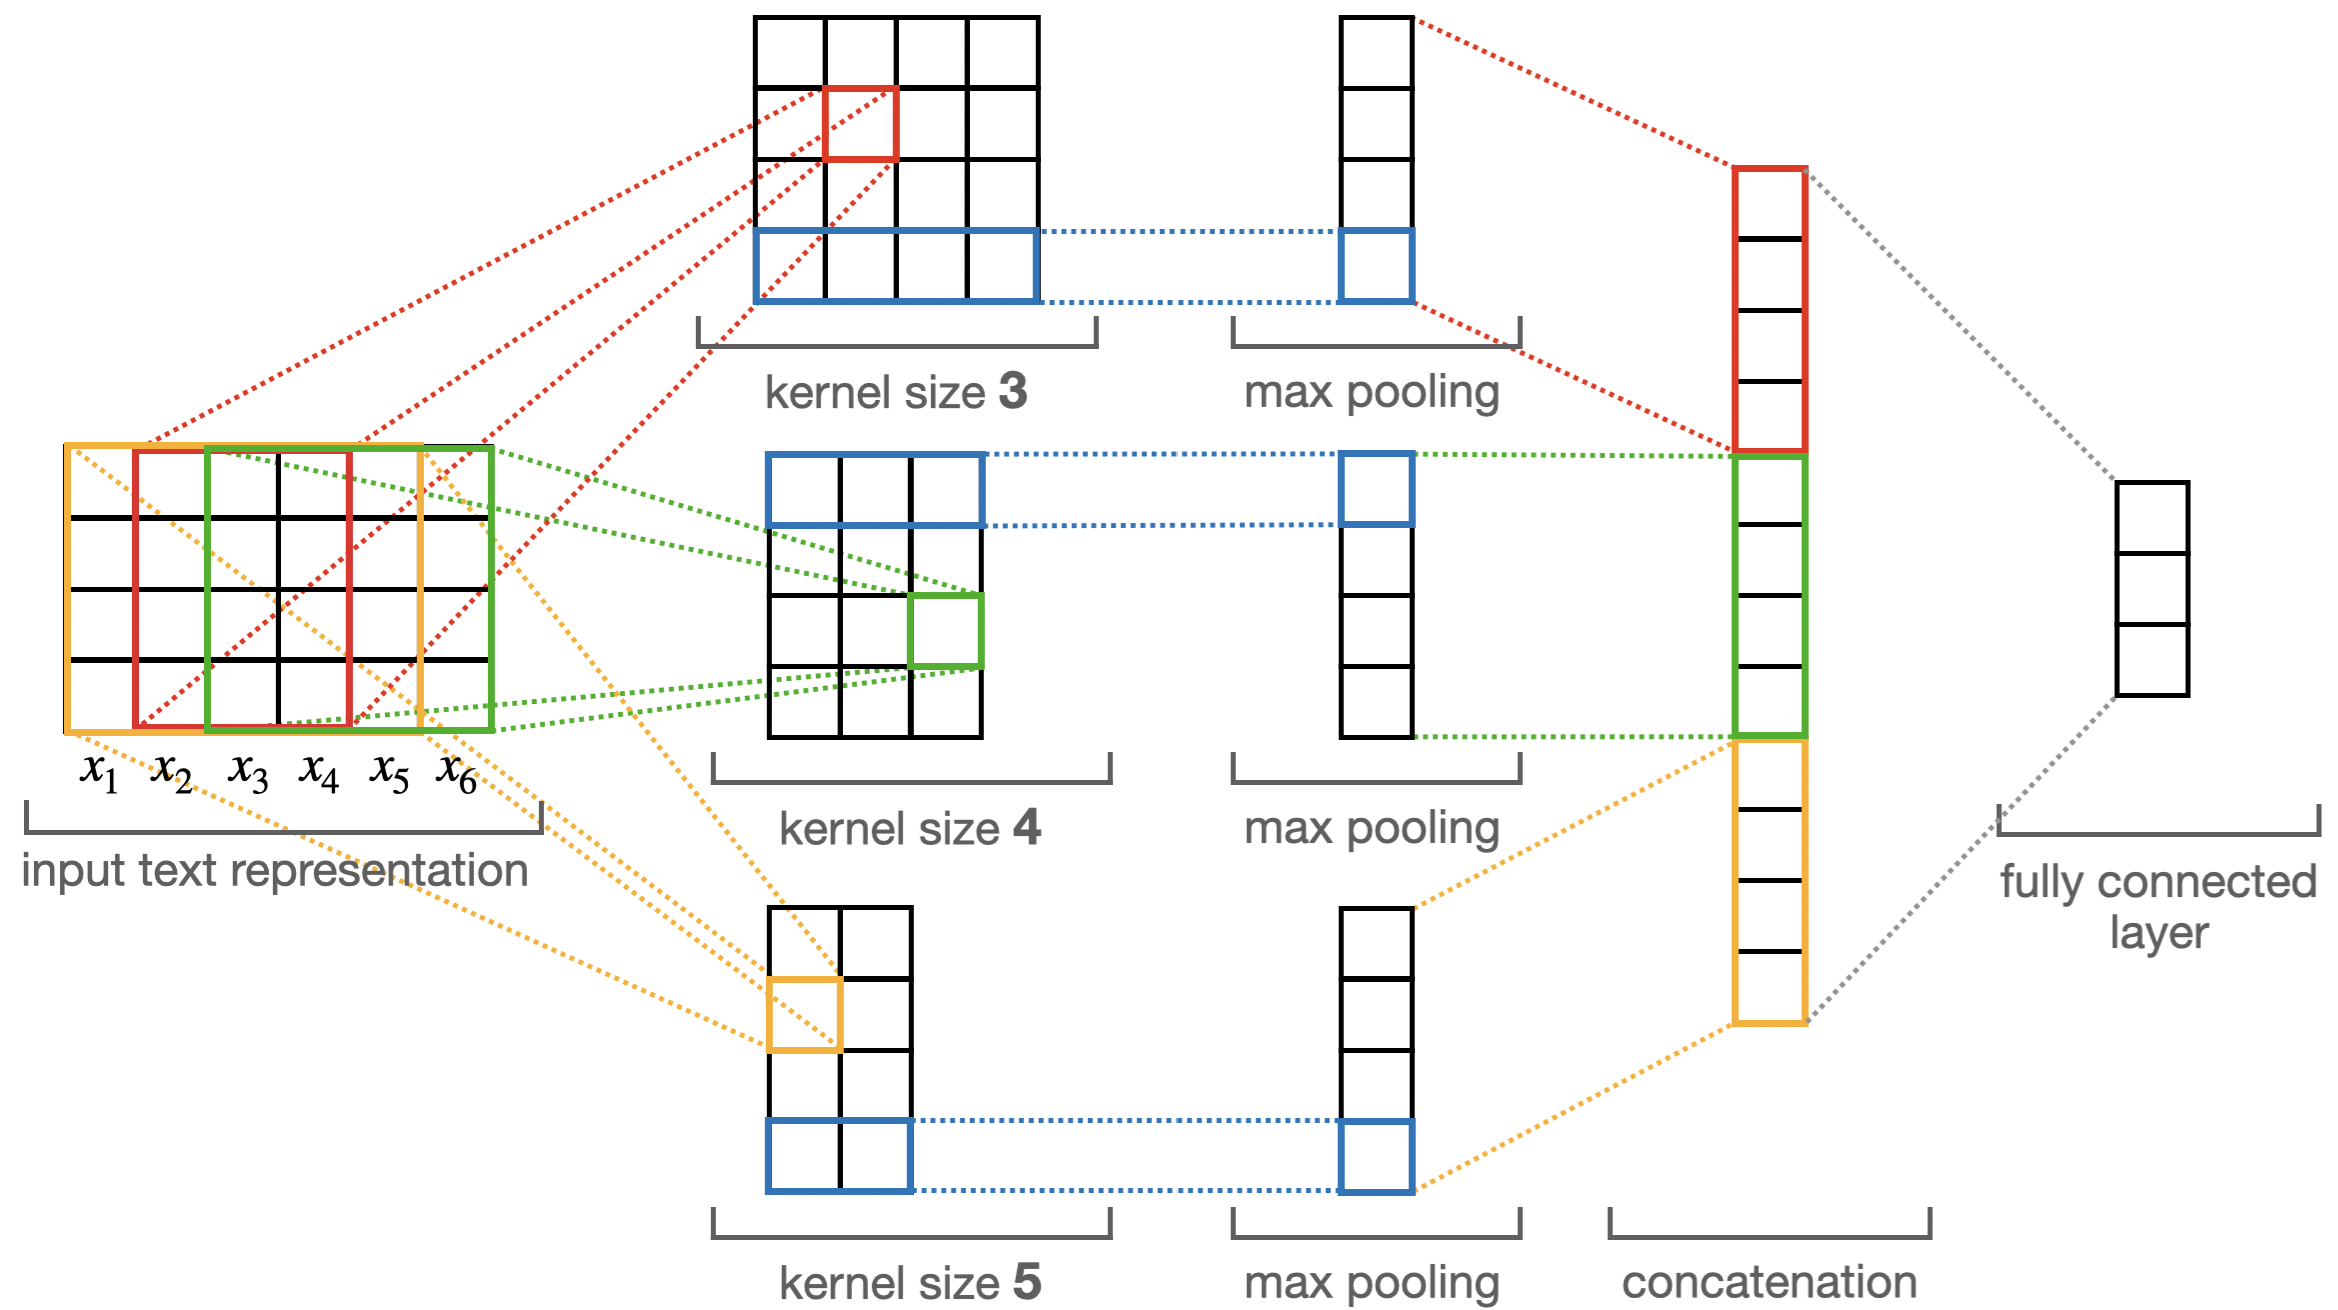


In [45]:
class TextCNN(nn.Module):
    def __init__(self, hid_dim=100, kernel_sizes=[3, 4, 5], n_classes=4):
        super().__init__()
            
        self.conv = nn.ModuleList([
            nn.Conv1d(in_channels=hid_dim, out_channels=hid_dim, kernel_size=k) for k in kernel_sizes
        ])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(len(kernel_sizes) * hid_dim, n_classes)

    def forward(self, x):
        # x: [batch_size, seq_len, dim]
        # меняем местами размерности, так как число каналов (dim) должно стоять на втором месте
        x = x.permute(0, 2, 1)
        
        x = [self.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(self.dropout(x))
        return x

In [46]:
# инициализируем модель и переводим на GPU, если есть
model = TextCNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [47]:
wandb.init(project="nlp_lesson2", name="textcnn")

In [48]:
# учим в течение 5 эпох
for epoch in range(5):
    train(model, w2v_train_loader, optimizer)
    test_accuracy, test_loss = evaluate(model, w2v_test_loader)

wandb.finish()

test_accuracy,▁▃▅▇█
test_loss,█▅▃▂▁
train_accuracy,▃▄▁▆▃▆▅▆▄▆▆▃▆▆▃▆▄▆▆▆▅▆▆▆▅▇▇▄▇▅▆▄▆▆▆▄█▇▆▆
train_loss,▃▆█▆▃▃▄▅█▇█▃▄▄█▂▃▅▄█▅▄▆▃▄▃▄▅▅▅▃▂▆▃▄▃▃▆▂▁
test_accuracy,0.90158
test_loss,0.28971
train_accuracy,0.96875
train_loss,0.16805


In [50]:
print('TextCNN')
print('Test accuracy:', test_accuracy)
print('Test loss:', test_loss)

TextCNN
Test accuracy: 0.90157896
Test loss: 0.2897062276695904


## Обучаемые эмбеддинги

Для обучения эмбеддингов нам нужно будет пересобрать датасет. Теперь он будет состоять не из эмбеддингов слов, а их индексов. Для каждого индекса модель будет выучивать свой эмбеддинг.

In [51]:
# берем словарь из word2vec, чтобы он точно не изменился
vocabulary = w2v_model.index_to_key

In [52]:
# будем использовать для конвертации слов в индексы
word2id = {word: i for i, word in enumerate(vocabulary)}
word2id['[PAD]'] = len(word2id)

In [53]:
def text2ids(texts):
    # конвертируем все тексты в наборы индексов
    ids = []
    for words in texts:
        ids.append(torch.tensor([word2id[word] for word in words if word in word2id]))

    return ids

In [54]:
train_ids = text2ids(lemmatized_train)
test_ids = text2ids(lemmatized_test)
train_dataset = list(zip(train_ids, labels_train))
test_dataset = list(zip(test_ids, labels_test))

In [55]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # та же самая функция обработки батча
    # только теперь мы имеем дело с индексами, поэтому паддим индексом специального символа
    ids, labels = zip(*batch)
    return (
        pad_sequence(ids, padding_value=word2id['[PAD]']).permute(1, 0),
        torch.tensor(labels)
    )

In [56]:
from torch.utils.data import DataLoader

ids_train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=True, batch_size=32)
ids_test_loader = DataLoader(test_dataset, collate_fn=collate_fn, shuffle=False, batch_size=8)

In [60]:
class EmbeddingTextCNN(TextCNN):
    def __init__(self, vocab_size, hid_dim=100, kernel_sizes=[3, 4, 5], n_classes=4):
        super().__init__(hid_dim, kernel_sizes, n_classes)
        
        self.embedding = nn.Embedding(vocab_size, hid_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = super().forward(x)
        return x

In [61]:
# инициализируем модель и переводим на GPU, если есть
model = EmbeddingTextCNN(vocab_size=len(word2id)).to(device)

# ставим скорость обучения в 2 раза больше, потому что иначе эмбеддинги будут долго учиться
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-3)

In [62]:
wandb.init(project="nlp_lesson2", name="textcnn_train_embeddings")

In [63]:
# учим в течение 10 эпох, так как помимо модели нужно обучить слой эмбеддингов
for epoch in range(10):
    train(model, ids_train_loader, optimizer)
    test_accuracy, test_loss = evaluate(model, ids_test_loader)

wandb.finish()

test_accuracy,▁▃▅▆▇▇████
test_loss,█▆▄▃▂▁▁▁▁▁
train_accuracy,▁▆▆▅▆▆▆▇▇▆▇▅▇▇▆▇▇▇▇▆▇▆▇█▇▆█▇▇██▇▇▆▇█▇███
train_loss,█▇██▇▇▄▇▆▆▅▄▃▄▇▂▃▄▂▂▄▂▃▃▄▃▂▄▃▃▅▃▄▅▂▂▁▅▃▅
test_accuracy,0.915
test_loss,0.26711
train_accuracy,0.96875
train_loss,0.19204


In [64]:
print('TextCNN train embeddings')
print('Test accuracy:', test_accuracy)
print('Test loss:', test_loss)

TextCNN train embeddings
Test accuracy: 0.915
Test loss: 0.26711142240680363


Добрались до качества TF-IDF. Но какой ценой?

## Объяснение предсказаний

На практике очень полезно бывает уметь объяснять, почему модель выдала то или иное предсказание. Для простейших моделей (линейныя регрессия, дерево решений) возможность интерпретации встроена по умолчанию. Однако в случае нейронных сетей все не так просто, потому что зависимость предсказаний от признаков имеет очень сложную структуру, поэтому приходится придумывать всякие трюки.

Вот некоторые из способов посмотреть внутрь модели:
* Изменить вход и посмотреть, как меняется предсказание
* Поискать примеры, которые максимизируют или минимизируют активации конкретных нейронов (_больше об этом на [distill.pub](https://distill.pub/2018/building-blocks/)_)
* Построить локальную _линейную_ аппроксимацию модели: [LIME article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)
* Обучить нейронную сеть, сопоставляющую каждому слову его важность с точки зрения модели [L2X article](https://arxiv.org/abs/1802.07814)

Мы остановимся на первом способе, как на самом простом.

In [65]:
@torch.no_grad()
def explain(model, tokens, label):
    model.eval()
    token_ids = torch.cat(text2ids([tokens])).unsqueeze(0)

    baseline_pred = model(token_ids.to(device)).cpu()
    baseline_prob = torch.softmax(baseline_pred, dim=-1)[0, label]

    drop_one_batch = []
    for t in range(len(token_ids[0])):
        drop_one_token_ids = torch.hstack([token_ids[:, :t], token_ids[:, t+1:]])
        drop_one_batch.append(drop_one_token_ids)        

    drop_one_batch = torch.cat(drop_one_batch)
    
    drop_one_pred = model(drop_one_batch.to(device)).cpu()
    drop_one_prob = torch.softmax(drop_one_pred, dim=-1)[:, label]
    
    diffs = baseline_prob - drop_one_prob
    
    return list(zip(tokens, diffs))

In [66]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [67]:
label_names = ["World", "Sports", "Business", "Sci/Tech"]

In [68]:
i = 0
print(label_names[labels_train[i]])
tokens_and_weights = explain(model, lemmatized_train[i], labels_train[i])
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

Business


wall st bear claw back black reuters reuters short seller wall street dwindling band ultra cynic seeing green

In [69]:
i = 42
print(label_names[labels_train[i]])
tokens_and_weights = explain(model, lemmatized_train[i], labels_train[i])
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

Business


technology company sue five ex employee marlborough based technology company suing five former employee including three senior manager allegedly conspiring employer working opening competing business

In [70]:
i = 1000
print(label_names[labels_train[i]])
tokens_and_weights = explain(model, lemmatized_train[i], labels_train[i])
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

Sci/Tech


european union extends microsoft time warner review brussels belgium ap european antitrust regulator said monday extended review deal microsoft corp msft time warner inc

In [71]:
i = 1023
print(label_names[labels_train[i]])
tokens_and_weights = explain(model, lemmatized_train[i], labels_train[i])
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

Sports


olympics thorpe beat phelps u suffers gold gap athens reuters australian swimmer ian thorpe beat arch rival michael phelps men 200 meter freestyle monday united state trailed china australia japan medal table day three olympic game